__Note:__ Для дальнейшей работы возьмем открытый датасет с кагла Alcohol Effects On Study (https://www.kaggle.com/datasets/whenamancodes/alcohol-effects-on-study)

### T-критерий Стьюдента для двух независимых выборок

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
from matplotlib import pyplot as plt
import seaborn as sns
from typing import Tuple, List
import plotly.graph_objs as go

In [2]:
df = pd.read_csv('Maths.csv')

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
df = df[['romantic', 'G3']]
df.head()

,romantic,G3
0,no,6
1,no,6
2,no,10
3,yes,15
4,no,10


__Note:__ Датасет содержит также информацию по средней оценке студента (по математике) и романтическому положению студента (в отношениях или нет). Будем проверять гипотезу "У студентов не состоящих в отношениях успеваемость выше (то есть средняя оценка), чем у тех кто состоит в отношениях". Сравнение будет производиться для средней оценки студентов для каждой группы. 

In [5]:
couple_grades = df[df.romantic == 'yes']['G3'].values
single_grades = df[df.romantic == 'no']['G3'].values

In [6]:
print(f'Количество студентов в группе "состоят в отношениях": {len(couple_grades)}')
print(f'Количество студентов в группе "не состоят в отношениях": {len(single_grades)}')

Количество студентов в группе "состоят в отношениях": 132
Количество студентов в группе "не состоят в отношениях": 263


__Note:__ Проверим, что признак оценок распределен нормально

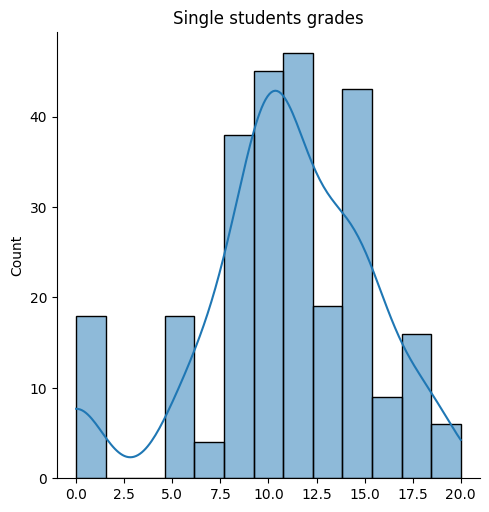

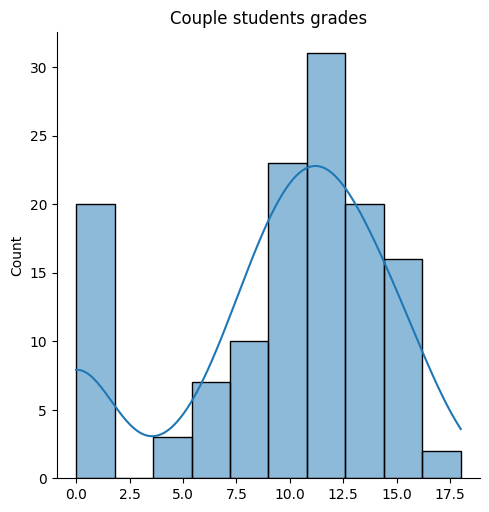

In [7]:
sns.displot(single_grades, kde=True).set(title='Single students grades')
sns.displot(couple_grades, kde=True).set(title='Couple students grades')


__Note:__ На самом деле видно, что распределение оценок - это смесь двуз нормальных распределений (о чем свидетельствуют два горба). Но сделаем пренебрежение левым горбом и будем считать что распределение почти нормальное

__Note__: Будем рассматривать уровень значимости $\alpha = 0.05$

In [8]:
def custom_ttest_ind(a: np.ndarray,
                     b: np.ndarray,
                     alpha: float,
                     alternative: str = 'two-sided') -> Tuple[float, float, str]:
    
    a_size = len(a)
    b_size = len(b)

    a_mean = a.mean()
    a_std = a.std(ddof=1)

    b_mean = b.mean()
    b_std = b.std(ddof=1)

    mr_a = a_std / np.sqrt(a_size)
    mr_b = b_std / np.sqrt(b_size)

    t_value = (a_mean - b_mean) / np.sqrt(mr_a**2 + mr_b**2)
    criterion_ddof = a_size + b_size - 2

    critical_value = sps.t.ppf(1.0 - alpha, criterion_ddof)
    
    p = sps.t.cdf(abs(t_value), criterion_ddof)
    if alternative == 'two-sided':
        p_value = (1 - p) * 2
    elif alternative == 'less':
        if t_value < 0:
            p_value = 1 - p
        else:
            p_value = p
    elif alternative == 'greater':
        if t_value < 0:
            p_value = p
        else:
            p_value = 1 - p
    else:
        raise ValueError("Please use only two-sided/less/greater alternative")
    
    if np.abs(t_value) > critical_value and (p_value < alpha):
        h0_verdict = 'Reject H0'
    else:
        h0_verdict = 'Failed to reject H0'

    return t_value, p_value, h0_verdict


In [9]:
alpha_ = 0.05
for alt in ['two-sided', 'less', 'greater']:
    custom_res = custom_ttest_ind(a = single_grades,
                                  b = couple_grades,
                                  alpha = alpha_,
                                  alternative = alt)

    lib_res = sps.ttest_ind(single_grades, couple_grades, equal_var=False, alternative = alt)
    
    print(f'Alternative : {alt}')
    print(custom_res)
    print(lib_res)
    print('\n' + '=' * 60 + '\n')

Alternative : two-sided
(2.5122003751250026, 0.012397883214704475, 'Reject H0')
Ttest_indResult(statistic=2.5122003751250026, pvalue=0.01265517134333271)


Alternative : less
(2.5122003751250026, 0.9938010583926478, 'Failed to reject H0')
Ttest_indResult(statistic=2.5122003751250026, pvalue=0.9936724143283336)


Alternative : greater
(2.5122003751250026, 0.006198941607352237, 'Reject H0')
Ttest_indResult(statistic=2.5122003751250026, pvalue=0.006327585671666355)




__Note:__ Используя 'two-sided' t-test мы отклоняем гипотезу о равенстве средних оценок групп студентов, состоящих и не состоящих в отношениях студентов.

### Bootstrap для оценки медианных и средних значений

In [10]:
from tqdm import tqdm 

def custom_bootstrap(data: np.ndarray,
                     num_sets: int,
                     samples_size: int) -> np.ndarray:
    
    data_sampled = []
    for set_ind in range(num_sets):
        cur_sampled = np.random.choice(data, size=samples_size, replace=True)
        data_sampled.append(cur_sampled)
    
    data_sampled = np.stack(data_sampled, axis=0)

    return data_sampled

def calc_stats_bootstrap(data: np.ndarray,
                         num_sets: int,
                         samples_size: int) -> dict[str, np.ndarray]:
    
    data_sampled = custom_bootstrap(data,
                                    num_sets,
                                    samples_size)
    
    sets_mean = np.mean(data_sampled, axis=1)
    sets_median = np.median(data_sampled, axis=1)

    return {'mean' : sets_mean, 'median' : sets_median}
    
    
num_sets = 1000
data_size = 10000

data_normal = sps.norm.rvs(loc=0, scale=1, size=data_size, random_state=0)
normal_stats = calc_stats_bootstrap(data_normal, num_sets, len(data_normal))

data_exp = sps.expon.rvs(loc=0, scale=1, size=data_size, random_state=0)
exp_stats = calc_stats_bootstrap(data_exp, num_sets, len(data_exp))

w = 0.3
data_normal_mixture = w * sps.norm.rvs(loc=0, scale=1, size=data_size, random_state=0) + \
                      (1 - w) * sps.norm.rvs(loc=10, scale=1, size=data_size, random_state=0)

normal_mixture_stats = calc_stats_bootstrap(data_normal_mixture, num_sets, len(data_normal_mixture))

In [11]:
alpha = 0.05

statistics = {
    'normal' : normal_stats,
    'exponential': exp_stats,
    'normal_mixture' : normal_mixture_stats
}

for type_name, statistics_values in statistics.items():
    for statistic_name, statistic_values in statistics_values.items():
        CI = np.percentile(statistic_values, (alpha * 100, (1 - alpha) * 100))
        print(f'{type_name} data distribution ({statistic_name}). \t CI = {CI}')

normal data distribution (mean). 	 CI = [-0.03301045 -0.00310315]
normal data distribution (median). 	 CI = [-0.04231181 -0.00555395]
exponential data distribution (mean). 	 CI = [0.97380449 1.00695808]
exponential data distribution (median). 	 CI = [0.66499044 0.69568153]
normal_mixture data distribution (mean). 	 CI = [6.96608601 6.99791907]
normal_mixture data distribution (median). 	 CI = [6.95704636 6.99498855]


### Мощность критерия для t-критерия и критерия Манна-Уитни

In [12]:
from collections import defaultdict


size = 50
n_sample = 10000


p_values_ttest = defaultdict(list)
p_values_mw = defaultdict(list)

for i in range(n_sample):
    x_a = sps.norm.rvs(loc=1, scale=1, size=size)
    x_b = sps.norm.rvs(loc=1, scale=1, size=size)
    p_values_ttest['norm'].append(sps.ttest_ind(x_a, x_b).pvalue)
    p_values_mw['norm'].append(sps.mannwhitneyu(x_a, x_b).pvalue)

    x_a = sps.norm.rvs(loc=1, scale=10, size=size)
    x_b = sps.norm.rvs(loc=1, scale=1, size=size)
    p_values_ttest['norm_diff'].append(sps.ttest_ind(x_a, x_b).pvalue)
    p_values_mw['norm_diff'].append(sps.mannwhitneyu(x_a, x_b).pvalue)

    x_a = sps.expon.rvs(loc=1, scale=1, size=size)
    x_b = sps.expon.rvs(loc=1, scale=1, size=size)
    p_values_ttest['expon'].append(sps.ttest_ind(x_a, x_b).pvalue)
    p_values_mw['expon'].append(sps.mannwhitneyu(x_a, x_b).pvalue)

    x_a = sps.expon.rvs(loc=1, scale=1.1, size=size)
    x_b = sps.expon.rvs(loc=1, scale=0.9, size=size)
    p_values_ttest['expon_diff'].append(sps.ttest_ind(x_a, x_b).pvalue)
    p_values_mw['expon_diff'].append(sps.mannwhitneyu(x_a, x_b).pvalue)


In [14]:
alpha = 0.05

print('T-test criterion power:')
for distr_name, p_values in p_values_ttest.items():
    p_values = np.array(p_values)
    criterion_power = p_values[p_values < alpha].shape[0] / n_sample
    print(f'distribution={distr_name}, criterion power = {criterion_power:.3f}')

print('*' * 50)

print('Mann-Whitney criterion power:')
for distr_name, p_values in p_values_mw.items():
    p_values = np.array(p_values)
    criterion_power = p_values[p_values < alpha].shape[0] / n_sample
    print(f'distribution={distr_name}, criterion power = {criterion_power:.3f}')

T-test criterion power:
distribution=norm, criterion power = 0.051
distribution=norm_diff, criterion power = 0.056
distribution=expon, criterion power = 0.050
distribution=expon_diff, criterion power = 0.160
**************************************************
Mann-Whitney criterion power:
distribution=norm, criterion power = 0.053
distribution=norm_diff, criterion power = 0.095
distribution=expon, criterion power = 0.050
distribution=expon_diff, criterion power = 0.132


### Корректность критериев (AA-тесты)

In [15]:
def get_probs_by_threshold(p_values: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    alpha_step = 0.01
    num_iters = 101
    probs = []
    x = [alpha_step * i for i in range(num_iters)]
    
    for i in range(num_iters):
        alpha_threshold = alpha_step * i
        probs.append(
            p_values[p_values < alpha_threshold].shape[0] / p_values.shape[0]
        )

    return np.array(probs), x

In [16]:
probs, x = get_probs_by_threshold(np.array(p_values_ttest['norm']))
fig = go.Figure([go.Scatter(x=x, y=probs, mode="markers", name="p_value"),
                 go.Scatter(x=x, y=x, mode="lines", name="uniform")])
fig.update_layout(height=600, width=600, title="Q-Q plot (Normal same distribution)")
fig

In [18]:
fig = go.Figure([go.Histogram(x=p_values_ttest['norm'], xbins={"start":0, "end":1, "size": 0.1})])
fig.update_layout(title='Q-Q plot (Normal same distribution)')
fig

In [68]:
probs, x = get_probs_by_threshold(np.array(p_values_ttest['norm_diff']))
fig = go.Figure([go.Scatter(x=x, y=probs, mode="markers", name="p_value"),
                 go.Scatter(x=x, y=x, mode="lines", name="uniform")])
fig.update_layout(height=600, width=600, title="Q-Q plot (Normal diff. distribution)")
fig

In [19]:
fig = go.Figure([go.Histogram(x=p_values_ttest['norm_diff'], xbins={"start":0, "end":1, "size": 0.1})])
fig.update_layout(title='Q-Q plot (Normal diff distribution)')
fig

In [70]:
probs, x = get_probs_by_threshold(np.array(p_values_ttest['expon']))
fig = go.Figure([go.Scatter(x=x, y=probs, mode="markers", name="p_value"),
                 go.Scatter(x=x, y=x, mode="lines", name="uniform")])
fig.update_layout(height=600, width=600, title="Q-Q plot (Exponential same distribution)")
fig

In [20]:
fig = go.Figure([go.Histogram(x=p_values_ttest['expon'], xbins={"start":0, "end":1, "size": 0.1})])
fig.update_layout(title='Q-Q plot (Exponential same distribution)')
fig

In [72]:
probs, x = get_probs_by_threshold(np.array(p_values_ttest['expon_diff']))
fig = go.Figure([go.Scatter(x=x, y=probs, mode="markers", name="p_value"),
                 go.Scatter(x=x, y=x, mode="lines", name="uniform")])
fig.update_layout(height=600, width=600, title="Q-Q plot (Exponential diff. distribution)")
fig

In [21]:
fig = go.Figure([go.Histogram(x=p_values_ttest['expon_diff'], xbins={"start":0, "end":1, "size": 0.1})])
fig.update_layout(title='Q-Q plot (Exponential diff distribution)')
fig